In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import math
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima import auto_arima
from pandas import DataFrame
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [3]:
# df here is the HDFC_6m dataset
# I will be working on this dataset for the entire predictions

df = pd.read_csv(r"/Users/aditibanjare/Downloads/HDFCBANK.NS.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-30,1555.599976,1570.000000,1551.599976,1568.250000,1550.225464,4524583
1,2021-08-31,1563.500000,1583.349976,1562.199951,1581.400024,1563.224365,6031288
2,2021-09-01,1575.000000,1598.000000,1574.500000,1579.099976,1560.950806,6211279
3,2021-09-02,1574.099976,1592.000000,1571.250000,1589.000000,1570.737061,4809262
4,2021-09-03,1586.099976,1598.000000,1568.300049,1576.050049,1557.935913,5367667
...,...,...,...,...,...,...,...
243,2022-08-22,1484.800049,1488.349976,1467.699951,1470.349976,1470.349976,4117033
244,2022-08-23,1453.300049,1475.949951,1450.400024,1465.800049,1465.800049,7483442
245,2022-08-24,1461.900024,1475.500000,1459.199951,1472.849976,1472.849976,6727760
246,2022-08-25,1479.900024,1486.800049,1457.000000,1464.849976,1464.849976,5911520


I will firstly list down the steps that I am going to follow - 

1. Exploratory Data Analysis - This involves - 
   1. Redundant data removal
   2. Conversion of ‘Date’ Attribute to dateTime and 
   3. Use of the grouping function to group ‘Date’ and ‘Close’
2. Stationarity Test
   1. ACF and PACF plots 
   2. Dicky Fuller Test
3. Auto ARIMA
   1. Computing Optimum values of p,d and q
4. Building the model

In [4]:
# checking for null values in df dataset

df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# since there are no null values in the df data set we can move forward

In [6]:
# Conversion of ‘Date’ Attribute to dateTime for df dataset
# This makes the dataet compatible of ARIMA model

type(df.Date[0])

str

In [7]:
df["Date"] = pd.to_datetime(df["Date"], format = '%Y-%m-%d')

In [8]:
type(df.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [9]:
# Use of the grouping function to group ‘Date’ and ‘Close’
# Used to group only the relevant attributes from the dataset

df_new = df.groupby('Date')[['Close']].mean()
df_new

,Close
Date,
2021-08-30,1568.250000
2021-08-31,1581.400024
2021-09-01,1579.099976
2021-09-02,1589.000000
2021-09-03,1576.050049
...,...
2022-08-22,1470.349976
2022-08-23,1465.800049
2022-08-24,1472.849976


In [10]:
# ACF and PACF plots
# A data is said to be stationary if the mean, variance and autocorrelation structure do not show any difference over time

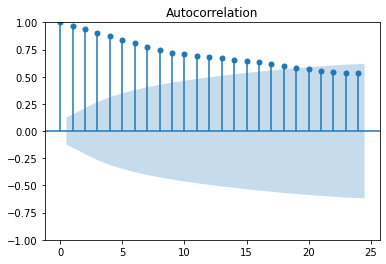

In [11]:
plot_acf(df_new['Close'])
pyplot.show()

/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


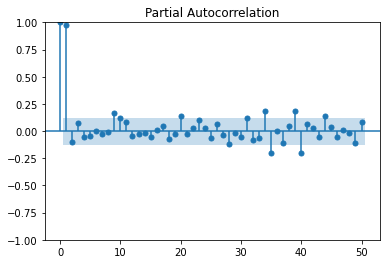

In [12]:
plot_pacf(df_new['Close'], lags = 50)
pyplot.show()

In [13]:
# Dicky Fuller Test
# For a dataset to be stationary, p-value must be less than 5%
# We assume that it is not so

In [14]:
result = adfuller(df_new['Close'])
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('#Lags Used : %f'% result[2])
print('Number of Observation Used: %f' % (result[3]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

(-2.011879142312083, 0.2813889216768192, 0, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 2120.483178767843)
ADF Statistic: -2.011879
p-value: 0.281389
#Lags Used : 0.000000
Number of Observation Used: 247.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [15]:
df_new['Close First Difference'] = df_new['Close'] - df_new['Close'].shift(1)
df_new['Close'].shift(1)

Date
2021-08-30            NaN
2021-08-31    1568.250000
2021-09-01    1581.400024
2021-09-02    1579.099976
2021-09-03    1589.000000
                 ...     
2022-08-22    1493.050049
2022-08-23    1470.349976
2022-08-24    1465.800049
2022-08-25    1472.849976
2022-08-26    1464.849976
Name: Close, Length: 248, dtype: float64

In [16]:
result1 = adfuller(df_new['Close First Difference'].dropna())
print(result1)
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
print('#Lags Used : %f'% result1[2])
print('Number of Observation Used: %f' % (result1[3]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

(-14.60170403849771, 4.155883575582108e-27, 0, 246, {'1%': -3.457215237265747, '5%': -2.873361841566324, '10%': -2.5730700760129555}, 2112.4241349695344)
ADF Statistic: -14.601704
p-value: 0.000000
#Lags Used : 0.000000
Number of Observation Used: 246.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


Text(0, 0.5, 'Price')

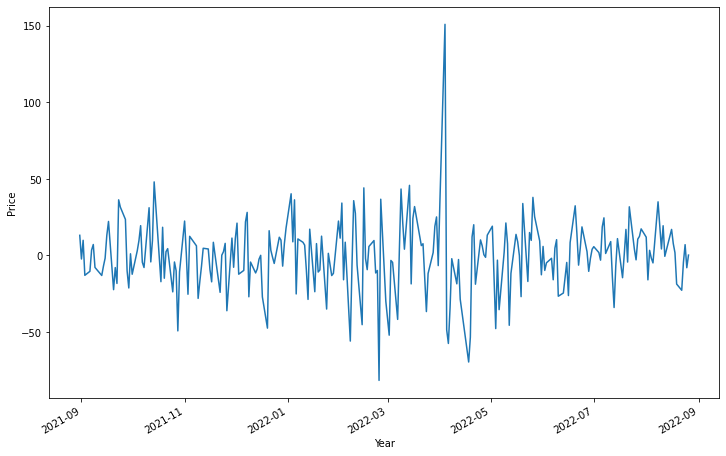

In [17]:
adfuller(df_new['Close First Difference'].dropna())
df_new['Close First Difference'].plot(figsize = (12,8))
plt.xlabel("Year")
plt.ylabel("Price")

In [18]:
# After the above steps the dataset has become stationary, so we move forward 
# Auto ARIMA, Computing Optimum values of p,d and q for the best results of forecasting for the ARIMA model.
# Model whose AIC value is the lowest

In [19]:
stepwise_fit = auto_arima(df_new['Close'],trace = True, suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2260.502, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2259.083, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2259.937, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2259.717, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2257.163, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2260.826, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.649 seconds


/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  248
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1127.581
Date:                Sun, 28 Aug 2022   AIC                           2257.163
Time:                        15:14:50   BIC                           2260.672
Sample:                             0   HQIC                          2258.576
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       540.4216     22.965     23.533      0.000     495.412     585.431
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):               524.37
Prob(Q):                              0.28   Pr

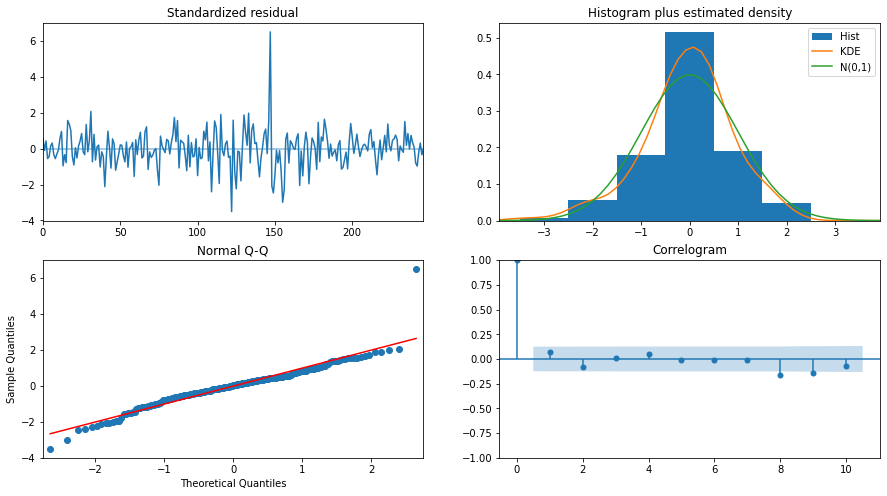

In [20]:
print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize = (15,8))
plt.show()

1. Top left - Uniform variance and fluctuates around a mean of zero

2. Top Right - Normal distribution with a mean of zero

3. Bottom left - Significant deviations indicate a skewed distribution

4. Bottom Right - The residual errors are not autocorrelated

In [21]:
# Now comes the final part of Building the model 

In [22]:
series = df_new['Close']
x = series.values
size = int(len(x) * 0.7)
train, test = x[0:size], x[size:len(x)] 
model = ARIMA(train, order=(0, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  173
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -802.323
Date:                Sun, 28 Aug 2022   AIC                           1606.646
Time:                        15:14:56   BIC                           1609.794
Sample:                             0   HQIC                          1607.923
                                - 173                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       659.4962     34.730     18.989      0.000     591.426     727.566
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               326.46
Prob(Q):                              0.50   Pr

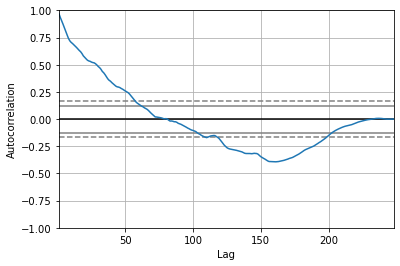

<Figure size 800x560 with 0 Axes>

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [24]:
# testing of the model

In [25]:
history = [i for i in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

print(predictions)

[1348.599976, 1303.050049, 1291.349976, 1305.099976, 1314.0, 1313.900024, 1287.050049, 1320.949951, 1304.0, 1318.949951, 1328.800049, 1366.699951, 1392.050049, 1401.550049, 1388.949951, 1394.849976, 1385.099976, 1380.300049, 1378.449951, 1362.599976, 1367.400024, 1377.699951, 1351.099976, 1326.599976, 1312.0, 1307.449951, 1281.300049, 1289.75, 1322.150024, 1336.550049, 1330.25, 1335.150024, 1353.800049, 1356.25, 1345.900024, 1343.949951, 1348.0, 1353.75, 1355.650024, 1352.599976, 1371.25, 1395.800049, 1397.099976, 1406.150024, 1391.800049, 1357.849976, 1351.050049, 1362.050049, 1347.550049, 1348.050049, 1365.050049, 1360.75, 1392.5, 1396.599976, 1393.75, 1404.400024, 1416.849976, 1434.199951, 1446.150024, 1430.25, 1433.599976, 1431.900024, 1427.050049, 1462.050049, 1466.300049, 1485.699951, 1485.150024, 1502.150024, 1509.900024, 1511.699951, 1493.050049, 1470.349976, 1465.800049, 1472.849976, 1464.849976]


In [26]:
# model performance test

In [27]:
mse = mean_squared_error(test, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions - test)/np.abs(test))
print('MAPE: '+str(mape))

MSE: 267.3421707147642
MAE: 12.69199541333334
RMSE: 16.350601539844465
MAPE: 0.009264621278288457


In [28]:
# Plotting the predicted prices from ARIMA model and real prices

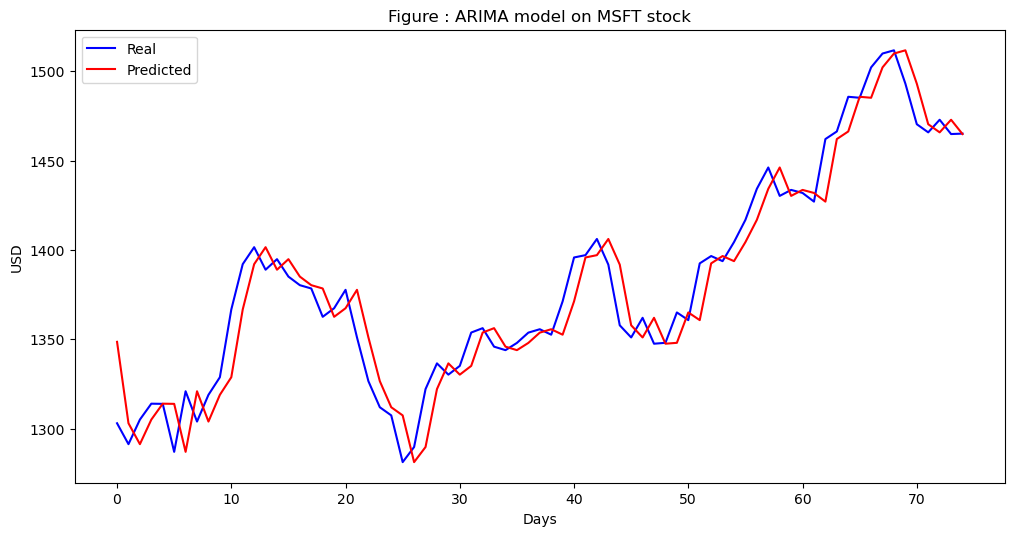

In [29]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure : ARIMA model on MSFT stock')
plt.legend()
plt.show()

In [30]:
# future predictions

In [31]:
pred = model_fit.predict(start = len(df_new), end = len(df_new)+30, typ = 'levels')
print(pred)

[1464.849976 1464.849976 1464.849976 1464.849976 1464.849976 1464.849976
 1464.849976 1464.849976 1464.849976 1464.849976 1464.849976 1464.849976
 1464.849976 1464.849976 1464.849976 1464.849976 1464.849976 1464.849976
 1464.849976 1464.849976 1464.849976 1464.849976 1464.849976 1464.849976
 1464.849976 1464.849976 1464.849976 1464.849976 1464.849976 1464.849976
 1464.849976]
